## Encoding by pronouciation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [49]:
import wn
from wn import morphy, validate
ewn = wn.Wordnet('ewn:2020')
m = morphy.Morphy(ewn)

In [3]:
pronouncing_dict_path = './cmudict.dict.txt'

In [224]:
dico = {}
with open(pronouncing_dict_path, 'r', encoding='utf-8') as file:
	for line in file.readlines():
		l = line.strip().split(' ')
		word = l[0]
		pronounciation = ' '.join(l[1:])
		# filter some non standard words
		if word.islower() and word.isalpha():
			dico[word] = pronounciation

In [225]:
len(dico)

117490

first check if the word exists in wordnet

In [62]:
def validate(word):
	# check if exists
	res = wn.synsets(word)
	if res != []:
		return True
	# otherwise check if as a derivation, the lemma exists
	for lemmas_per_pos in m(word).values():
		for lemma in lemmas_per_pos:
			res = wn.synsets(lemma)
			# if there exists one, return
			if res != []:
				return True
	return False

In [64]:
from tqdm import tqdm

In [65]:
non_words = []
for word in tqdm(dico.keys()):
	if not validate(word):
		non_words.append(word)

100%|██████████| 117490/117490 [01:01<00:00, 1897.98it/s]


In [66]:
len(non_words)

65445

In [226]:
with open('./non_wordnet_words.txt', 'w', encoding='utf-8') as file:
	for non_word in non_words:
		file.write(non_word+'\n')

However, wordnet excludes some function words, they should be taken into account in dictionary

In [222]:
with open('./wordnet_stopwords.txt', 'r', encoding='utf-8') as file:
	stop_words = file.read().splitlines()

In [227]:
for non_word in non_words:
	if not non_word in stop_words:
		dico.pop(non_word)

In [228]:
len(dico)

52123

now we get a well pronounced, wordnet-validated dictionary

In [229]:
df = pd.DataFrame.from_dict(dico, orient='index', columns = ['sound'])

In [290]:
df.index.name = 'word'

In [291]:
df

,sound,COUNT,encoding,vowel_free
word,,,,
a,AH0,4496.0,A,A
aaa,T R IH2 P AH0 L EY1,NaN,AAA,AAA
aachen,AA1 K AH0 N,NaN,QKQN,QKN
aalborg,AO1 L B AO0 R G,NaN,QLBQRG,QLBRG
aalto,AA1 L T OW2,NaN,QLTQ,QLTQ
...,...,...,...,...
zuni,Z UW1 N IY2,NaN,ZUNI,ZUNI
zurich,Z UH1 R IH0 K,NaN,ZQRQK,ZRK
zweig,Z W AY1 G,NaN,ZWQG,ZWG


In [231]:
df_freq = pd.read_csv('./dict_en.yaml', sep = '\t', index_col=0, usecols=[1,2])
df_freq

,COUNT
WORD,
in,4501
a,4496
as,4491
it,4486
be,4481
...,...
obsessivity,0
radiolocate,0
pelecypodous,0


In [232]:
df = df.join(df_freq)

In [294]:
df.rename(columns={'COUNT': 'freq'}, inplace=True)

In [77]:
def encode(phonemes):
	vowels = re.compile('(AO|UW|EH|AH|AA|IY|IH|UH|AE|AW|AY|ER|EY|OW|OY)\d*', re.VERBOSE)
	phonemes = re.sub(vowels, 'Q', phonemes)
	complex_consonant = re.compile('CH|DH|HH|JH|NG|SH|TH|ZH|')
	# complex consonants
	phonemes = re.sub('HH', 'H', phonemes)
	phonemes = re.sub('CH', 'C', phonemes)
	phonemes = re.sub('JH', 'J', phonemes)
	phonemes = re.sub('TH', 'X', phonemes)
	phonemes = re.sub('DH', 'X', phonemes)
	phonemes = re.sub('SH', 'U', phonemes)
	phonemes = re.sub('ZH', 'O', phonemes)
	phonemes = re.sub('NG', 'I', phonemes)
	
	# remove whitespaces
	phonemes = re.sub(' ', '', phonemes)

	return phonemes

In [78]:
def transcribe(phonemes_list):
	encoding_list = []
	for phonemes in phonemes_list:
		encoding_list.append(encode(phonemes))
	return encoding_list

In [262]:
encoding_list = transcribe(df.sound.astype('str'))
df['encoding'] = encoding_list

In [263]:
df

,sound,COUNT,encoding
a,AH0,4496.0,Q
aaa,T R IH2 P AH0 L EY1,NaN,TRQPQLQ
aachen,AA1 K AH0 N,NaN,QKQN
aalborg,AO1 L B AO0 R G,NaN,QLBQRG
aalto,AA1 L T OW2,NaN,QLTQ
...,...,...,...
zuni,Z UW1 N IY2,NaN,ZQNQ
zurich,Z UH1 R IH0 K,NaN,ZQRQK
zweig,Z W AY1 G,NaN,ZWQG
zydeco,Z AY1 D AH0 K OW2,NaN,ZQDQKQ


delete non-initial vowels

In [264]:
def remove_vowels(encoding_list):
	res = []
	for encoding in encoding_list:
		if len(encoding) > 1:
			res.append(encoding[0] + re.sub('Q','', encoding[1:-1]) + encoding[-1])
		else:
			res.append(encoding)
	return res

Normalization

We hope that:
1. the plurals and the third person single form are uniformly terminated with S(instead of Z or other possible sound)
2. the past particles are uniformly terminated with E(instead of T or D or other possible sound)
3. the present particles are uniformly terminated with I(this is already done since we encode NG sound by I)

you can take these terminations as a grammatical symbol

In [235]:
df.encoding.loc[(df.index.str.contains('s$', regex=True) == True)]

aardvarks           QRDVQRKS
aarhus                  QHQS
abacus                QBQKQS
abalones            QBQLQNQZ
abandonments    QBQNDQNMQNTS
                    ...     
zones                   ZQNZ
zoologists       ZQWQLQJQSTS
zooms                   ZQMZ
zoos                     ZQZ
zucchinis            ZQKQNQZ
Name: encoding, Length: 13316, dtype: object

In [236]:
df.encoding.loc[(df.index.str.contains('ed$', regex=True) == True)]

abandoned         QBQNDQND
abashed              QBQUT
abated              QBQTQD
abbreviated    QBRQVQYQTQD
abdicated        QBDQKQTQD
                  ...     
zigzagged          ZQGZQGD
zipped                ZQPT
zippered             ZQPQD
zoned                 ZQND
zoomed                ZQMD
Name: encoding, Length: 4701, dtype: object

In [237]:
df.encoding.loc[(df.index.str.contains('ing$', regex=True) == True)]

abandoning        QBQNDQNQI
abating              QBQTQI
abbreviating    QBRQVQYQTQI
abdicating        QBDQKQTQI
abducting          QBDQKTQI
                   ...     
zing                    ZQI
zippering           ZQPQRQI
zipping               ZQPQI
zoning                ZQNQI
zooming               ZQMQI
Name: encoding, Length: 4323, dtype: object

In [267]:
def normalize(encodings: pd.Series):
	plurals_or_third_single_form  = re.compile('s$')
	past_particle = re.compile('ed$')
	present_particle = re.compile('ing$')

	# print(encodings.head())
	# replace voiced plural suffix
	res1 = encodings.loc[(encodings.index.str.contains(plurals_or_third_single_form, regex=True) == True)].str.replace('Z$', 'S', regex=True)
	# print(res1.head())
	# remove -ed, sometimes together with a vowel sound i.
	res2 = encodings.loc[(encodings.index.str.contains(past_particle, regex=True) == True)].str.replace('Q?[T|D]$', 'E', regex = True)
	# print(res2.head())
	# remove -ing, always with a vowel sound i
	res3 = encodings.loc[(encodings.index.str.contains(present_particle, regex=True) == True)].str.replace('Q?I$', 'I', regex = True)
	# print(res3.head())
	
	res = pd.concat([res1, res2, res3])
	return res

In [266]:
res = normalize(df.encoding)

In [272]:
df.loc[['abandons','abandoned','abandoning'], 'encoding']

abandons       QBQNDQNZ
abandoned      QBQNDQND
abandoning    QBQNDQNQI
Name: encoding, dtype: object

In [273]:
df.loc[res.index, 'encoding'] = res

In [274]:
df.loc[['abandons','abandoned','abandoning'], 'encoding']

abandons      QBQNDQNS
abandoned     QBQNDQNE
abandoning    QBQNDQNI
Name: encoding, dtype: object

Manually correct exceptions

Type letters, 2-grams, 3-grams, 4-grams by themselve  

In [276]:
df.loc[(df.index.str.len() <= 4), 'encoding'] = df.index[(df.index.str.len() <= 4)].str.upper()

In [277]:
df.loc[(df.index.str.len() == 2) & (df.COUNT >= 0), ['encoding','COUNT']][:60]

,encoding,COUNT
ad,AD,920.0
ai,AI,150.0
al,AL,3163.0
am,AM,3592.0
an,AN,4431.0
as,AS,4491.0
at,AT,4446.0
au,AU,239.0
av,AV,151.0
ax,AX,61.0


In [278]:
df.loc[(df.index.str.len() == 4) & (df.encoding.str.len() == 4), ['encoding','COUNT']]

,encoding,COUNT
abbe,ABBE,NaN
abcs,ABCS,NaN
abed,ABED,6.0
abel,ABEL,59.0
abet,ABET,8.0
...,...,...
zone,ZONE,914.0
zoom,ZOOM,28.0
zoos,ZOOS,NaN
zulu,ZULU,22.0


Detect inefficient encoding

In [279]:
df.loc[(df.index.str.len() < df.encoding.str.len()), ['encoding','COUNT']]

,encoding,COUNT
absenteeism,QBSQNTQYQZQM,23.0
absolutism,QBSQLQTQZQM,16.0
abuses,QBYQSQS,NaN
academia,QKQDQMQYQ,33.0
acadia,QKQDQYQ,NaN
...,...,...
zodiac,ZQDQYQK,16.0
zoologist,ZQWQLQJQST,9.0
zoologists,ZQWQLQJQSTS,NaN
zoology,ZQWQLQJQ,83.0


In [284]:
encoding_normalized = df['encoding'].copy()

In [288]:
df['vowel_free'] = remove_vowels(df.encoding) 

In [296]:
df.to_csv('./dict_en.csv')

## Encoding Statistics

encoding length

In [282]:
def plot_string_length_freq(encoding_series: pd.Series):
	wd_length = list(map(len, encoding_series))
	plt.hist(np.array(wd_length),alpha = 0.5, bins=range(min(wd_length), max(wd_length)+1,1), label=encoding_series.name)
	longest, shortest, average = np.max(wd_length), np.min(wd_length), np.mean(wd_length)
	print('longest length: {}, shortest length: {}, average length: {}'.format(longest, shortest, average))
	return longest, shortest, average

we notice that the encoding length is dramatically reduced. On average cut down 3.3 letters (nearly 34%)

longest length: 19, shortest length: 1, average length: 6.810582660245957
longest length: 13, shortest length: 1, average length: 4.791397271837768
longest length: 20, shortest length: 1, average length: 7.912552999635477


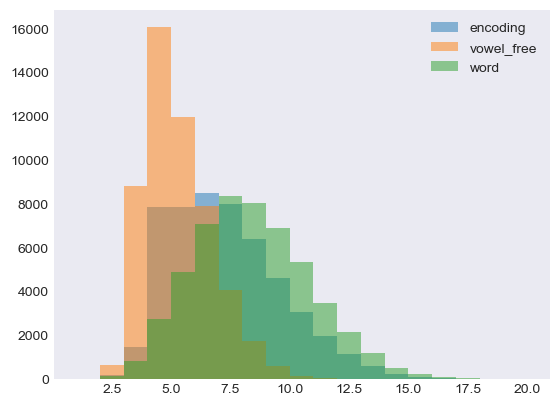

In [292]:
plt.style.use('seaborn-v0_8-dark')
plot_string_length_freq(encoding_normalized)
plot_string_length_freq(df.vowel_free)
plot_string_length_freq(df.index)
plt.legend()

coincident codes: counts of words with same encoding

In [ ]:
encoding_counts = df_final.encoding_abjad.value_counts()

coincide encoding rate is 14%

In [ ]:
print(np.unique(encoding_counts,return_counts=True))
print(np.unique(encoding_counts,return_counts=True)[1][0]/np.unique(encoding_counts,return_counts=True)[1].sum())

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 20], dtype=int64), array([32205,  3512,   866,   343,   162,   123,    78,    42,    37,
          23,     7,    12,    13,     7,     3,     3,     2,     4,
           1], dtype=int64))
0.8601073631920519


(array([3.2205e+04, 3.5120e+03, 8.6600e+02, 3.4300e+02, 1.6200e+02,
        1.2300e+02, 7.8000e+01, 4.2000e+01, 3.7000e+01, 2.3000e+01,
        7.0000e+00, 1.2000e+01, 1.3000e+01, 7.0000e+00, 3.0000e+00,
        3.0000e+00, 2.0000e+00, 4.0000e+00, 1.0000e+00]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20.]),
 <BarContainer object of 19 artists>)

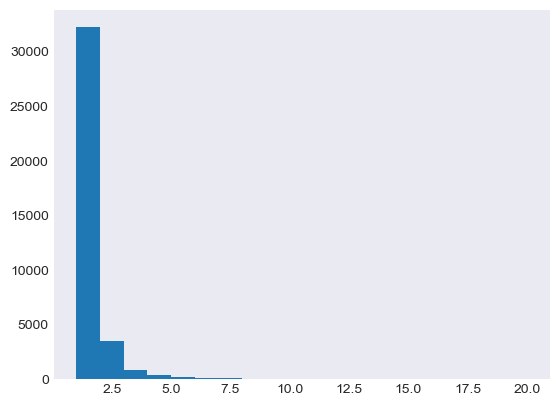

In [ ]:
plt.hist(encoding_counts,bins=range(min(encoding_counts), max(encoding_counts)+1,1))

Over 99% encodings has a less than 5 coincide codes

In [ ]:
encoding_counts.quantile(0.99)

5.0

There are many ways to reduce the coincide encoding rate, first let's study the coincide encoding length.
We can tolerate coincide codes less than 5

In [ ]:
coincident_codes = encoding_counts[encoding_counts > 5].index

longest length: 5, shortest length: 2, average length: 2.895774647887324


(5, 2, 2.895774647887324)

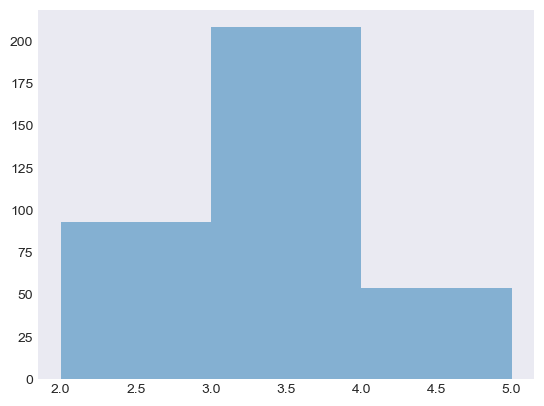

In [ ]:
plot_string_length_freq(coincident_codes)

They are between 2 to 5.

length of words that are encoded by coincident codes

longest length: 9, shortest length: 4, average length: 5.07639366827254


(9, 4, 5.07639366827254)

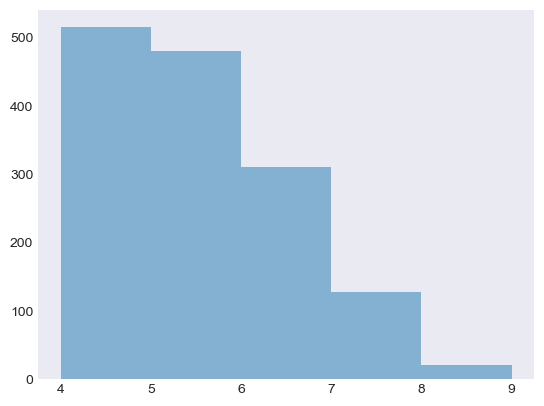

In [ ]:
collision_word = df_final[df_final.encoding_abjad.isin(coincident_codes) & df_final.COUNT > 0].WORD
plot_string_length_freq(collision_word)

In [ ]:
df_pronounced = df_final.loc[df_final['sound'].notnull()]
df_pronounced